
# ?1_fMRI_Correlations.ipynb

Original code from Eshin Jolly & modified for personal use




You'll need 2 things to do an ISC analysis:  

1) Nifti file(s) containing ROI masks within which to compute ISC - this can either be a single 4d file that several ROI masks within it, a single 3d file with just 1 ROI mask, a single 3d file within multiple ROIs indicated by different non-overlapping integer value at each voxel  

2) 4d Nifti files for all subjects to correlate

In [1]:
import nltools
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import os

% matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
data = Brain_Data("./data/sub-145/func/sub-145_self_concat.nii.gz")

(68, 80, 68, 470)
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x11205d590>, <nilearn.input_data.nifti_spheres_masker._ExtractionFunctor object at 0x119dc5810>, 
{ 'allow_overlap': False,
  'detrend': True,
  'high_pass': 0.01,
  'low_pass': 0.1,
  'mask_img': None,
  'radius': 8,
  'seeds': [(-56, -4, -10), (56, -4, -10)],
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': 2}, confounds=None, memory_level=1, verbose=1, memory=Memory(cachedir='nilearn_cache/joblib'))
[NiftiSpheresMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(68, 80, 68, 470),
affine=array([[   2.9000001,   -0.       ,   -0.       ,  -96.       ],
       [  -0.       ,    2.9000001,   -0.       , -132.       ],
       [   0.       ,    
[NiftiSpheresMasker.transform_single_imgs] Extracting region signals
[NiftiSpheresMasker.transfo

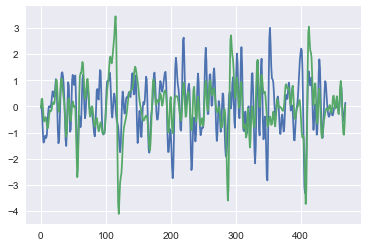

In [10]:
# Plot Video Splitting to verify
from nilearn import image
from nilearn import plotting
from nilearn import input_data


#Load original and cut data
bold_input = image.smooth_img("./data/sub-184/func/sub-184_other_concat.nii.gz", fwhm=3)

print(bold_input.shape)

#Guess auditiory cortex seed
aud_coords = [(-56,-4,-10),(56,-4,-10)]
labels = ['Auditory Cortex - L', 'Auditory Cortex - R']

#Make mask of auditory cortex
masker = input_data.NiftiSpheresMasker(
    aud_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=1)


time_series = masker.fit_transform(bold_input)

for time_serie, label in zip(time_series.T, labels):
    plt.plot(time_serie, label=label)


In [3]:
## Set up Folders

folder_path = "."

## Set up Mask

mask = 'Auditory.nii.gz'
mask_region = "Auditory"

print(1)

## Set up Video and Participants
video = '_self_concat.nii.gz'
subjects = [ '145', '157', '168', '184', '200', '214',  '219', '220', '222', '223', '229', '245', '253', '257', '263',  '267', '270', '277']
num_subs = len(subjects)

print(2)

subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func',  'sub-' + subjects[0] + '_self_concat.nii.gz')
num_TRs = Brain_Data(subject).shape()[0]
    
print(3)
    
# View Mask
mask = Brain_Data(data = folder_path + '/masked_data/' + mask) # this now a 1d array of voxels containing 1's and 0s
mask.plot()

1
2


KeyboardInterrupt: 

In [ ]:
self_other = 'self'

subjects = [ '145' ]

num_subs = len(subjects)

subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'sub-' + subjects + '_self_concat.nii.gz')
num_TRs = Brain_Data(subject).shape()[0]

subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 

for i, subject in enumerate(subjects):

    #try:

    subject_path = os.path.join(folder_path,'data', 'sub-' + subject, 'func', 'sub-' + subjects + '_self_concat.nii.gz')
    print(subject_path)

    # Load in their data
    sub_dat = Brain_Data(subject_path)

    # Extract mean time-series from ROI
    sub_roi = sub_dat.extract_roi(mask)

    data_frame = pd.DataFrame(sub_roi)

    print(sub_roi)


    output = os.path.join(folder_path, 'masked_data', mask_region, 'sub-' + subjects + '_self_concat' + mask + 'mask.csv')

    data_frame.to_csv(output, header=None)



In [ ]:
#Lets say you want to compute the ISC within an ROI (i.e. the pair-wise correlation of subjects average time-series across the entire ROI)
#Below assumes you have just a single mask, but you can easily adapt this by adding another loop over ROIs, e.g. for roi in mask: ...

#Get masked timeseries (averaged)


for video in range(6,17):
    subjects = [ '145', '157', '168', '184', '200', '214',  '219', '220', '222', '223', '229', '245', '253', '257', '263',  '267', '270', '277']
    subjects = [ '145' ]

    num_subs = len(subjects)

    subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')
    num_TRs = Brain_Data(subject).shape()[0]
    
    subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 

    for i, subject in enumerate(subjects):

        #try:

        subject_path = os.path.join(folder_path,'data', 'sub-' + subject, 'func', 'video_' + str(video) + '.nii.gz')
        print(subject_path)

        # Load in their data
        sub_dat = Brain_Data(subject_path)

        # Extract mean time-series from ROI
        sub_roi = sub_dat.extract_roi(mask)

        data_frame = pd.DataFrame(sub_roi)
        
        print(sub_roi)
        
        
        output = os.path.join(folder_path, 'masked_data', mask_region, subject + '_video' + str(video) + 'mask.csv')

        data_frame.to_csv(output, header=None)

        #except:
         #   pass

In [ ]:
## Load data and compute ISC

video=5

#Cutting off time series as a problem solivng measure
subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')

num_TRs = Brain_Data(subject).shape()[0] - 2

subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 

for i, subject in enumerate(subjects):
    csv_path = os.path.join(folder_path, 'masked_csv', mask_region,  subject + "_video" + str(video) + "mask.csv")
    #print(subject)

    #try: 
        # Load in their data
    sub_roi = pd.read_csv(csv_path, header=None)
    subject_timeseres[i,:] = pd.DataFrame(sub_roi).iloc[ 0:num_TRs ,1] # just grab the numpy array values (normally just [1])
    # except: pass


# Now compute pairwise correlations 
sub_corrs = 1 - pairwise_distances(subject_timeseres,metric='correlation') # I'm subtracting by 1 because pairwise_distance gives you correlation distances (i.e. values from 0-2), this just converts from -1 to 1

panda_corrs = pd.DataFrame(sub_corrs)
panda_corrs.columns = subjects
panda_corrs.index = subjects

pd.DataFrame(panda_corrs).to_csv('/Volumes/AdditionalStorage/ISC_Analysis/masked_csv/dDMN/video_' \
                                  + str(video)\
                                  + '_fMRIcorrelations.csv')



# Save it as an adjacency matrix
sub_ISC = Adjacency(data=sub_corrs)



In [ ]:
## Plot Group ISC

sns.set(style="white")

# Compute the correlation matrix
corr = sub_corrs

# Genesampling_rate a mask for the upper triangle
mask2 = np.zeros_like(corr, dtype=np.bool)
mask2[np.triu_indices_from(mask2)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


sns.heatmap(corr, vmax=.6, center=0,
            square=True, mask=mask2, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_xticklabels(subjects); 
ax.set_yticklabels(subjects); 

In [ ]:
# Plot ISC Timeseries


plot_timeseries = pd.DataFrame(subject_timeseres).transpose().reset_index()

plot_timeseries = (plot_timeseries - plot_timeseries.mean()) / (plot_timeseries.max() - plot_timeseries.min())


plot_timeseries = plot_timeseries.loc[:, (plot_timeseries != 0).any(axis=0)]
plot_timeseries['index'] = plot_timeseries.index + 1

x = plot_timeseries['index']
y = plot_timeseries.drop(['index'], axis=1)

plt.figure(figsize=(14,4))
plt.style.use('ggplot')

plt.title("Video: " + str(video))
plt.ylabel('Z Scored Activation')
plt.xlabel('Time (in TR)')


plt.plot(x, y, '-', linewidth=3, alpha=.7);




x = plot_timeseries['index']
y = plot_timeseries[10]

plt.plot(x, y, '--', linewidth=3, alpha=.7);

In [ ]:
# # Compute Subject Level Z-Scored Correlations
# transformedcorrs = pd.DataFrame(sub_corrs)
# transformedcorrs = transformedcorrs.replace(1,nan)
# #transformedcorrs = 0.5*np.log((1+transformedcorrs)/(1-transformedcorrs))

# transformedcorrs.mean()

# transformedcorrs


Few other pointers:  

If you want to do ISC for multiple ROIs you'll probably want to do something like load in a single subject, loop over a `Brain_Data` object containing multiple ROIs, use the `extract` method to grab mean timeseries from each, then save all those to a single csv file for that subject using pandas or numpy. Then after you've done that for each subject just load in their csv files and proceed with correlating them as you want. This probably the fastest way to do it because very few computers can load say 30 subjects full time-series of a few minutes into RAM at once (unless maybe the time-series are very short). So this way just extracts all the ROIs for each subject first then lets you do whatever analyses you want on them. 